In [370]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [340]:
import os, sklearn, math
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from joblib import dump, load

tf.random.set_seed(42)

data = '231007_1358_2kPa_160_Data'
dataname = data+'_B17'
filename = 'myData/'+data+'.csv'
SD1 = pd.read_csv(filename)
SD1=SD1.iloc[:,:40]
SensorData1 = SD1

In [341]:
SD1.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Sx10,Sx11,...,Sx46,Sx47,Sx50,Sx51,Sx52,Sx53,Force,z,theta,r
count,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,...,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000
mean,68.836789,66.664087,66.448300,66.660394,60.358478,58.665671,62.456011,67.717823,74.969260,61.448199,...,58.256235,57.532022,60.720177,62.691321,68.834362,68.473376,160.689166,40.168335,169.859413,3.199520
std,6.489444,7.605684,14.020375,7.580767,11.137975,8.161428,10.354728,9.969442,9.820515,9.531502,...,10.768215,11.890899,8.211881,9.098487,9.057852,10.329920,105.233097,24.075258,103.754363,1.600072
min,52.900000,54.400000,49.000000,57.100000,42.700000,50.900000,49.100000,55.300000,59.200000,50.100000,...,46.800000,47.500000,48.800000,52.500000,51.900000,53.100000,-455.760000,0.000000,0.000000,0.800000
25%,68.200000,66.000000,65.400000,66.000000,59.700000,57.900000,61.600000,66.600000,74.300000,60.700000,...,57.500000,56.800000,59.800000,62.000000,68.100000,67.800000,67.327500,20.000000,80.000000,1.600000
50%,69.000000,66.700000,66.600000,66.700000,60.400000,58.600000,62.400000,67.500000,75.000000,61.500000,...,58.200000,57.600000,60.800000,62.700000,68.900000,68.500000,157.920000,40.000000,160.000000,3.200000
75%,69.600000,67.400000,67.500000,67.300000,61.000000,59.300000,63.200000,68.700000,75.600000,62.100000,...,58.900000,58.300000,61.700000,63.400000,69.600000,69.300000,240.740000,60.000000,260.000000,4.800000
max,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,...,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,453.030000,80.000000,340.000000,5.600000


In [342]:
SDreal = SD1
SDreal["z"] *= 2

In [343]:
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Sx10,Sx11,...,Sx46,Sx47,Sx50,Sx51,Sx52,Sx53,Force,z,theta,r
count,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,...,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000,108260.000000
mean,68.836789,66.664087,66.448300,66.660394,60.358478,58.665671,62.456011,67.717823,74.969260,61.448199,...,58.256235,57.532022,60.720177,62.691321,68.834362,68.473376,160.689166,80.336671,169.859413,3.199520
std,6.489444,7.605684,14.020375,7.580767,11.137975,8.161428,10.354728,9.969442,9.820515,9.531502,...,10.768215,11.890899,8.211881,9.098487,9.057852,10.329920,105.233097,48.150515,103.754363,1.600072
min,52.900000,54.400000,49.000000,57.100000,42.700000,50.900000,49.100000,55.300000,59.200000,50.100000,...,46.800000,47.500000,48.800000,52.500000,51.900000,53.100000,-455.760000,0.000000,0.000000,0.800000
25%,68.200000,66.000000,65.400000,66.000000,59.700000,57.900000,61.600000,66.600000,74.300000,60.700000,...,57.500000,56.800000,59.800000,62.000000,68.100000,67.800000,67.327500,40.000000,80.000000,1.600000
50%,69.000000,66.700000,66.600000,66.700000,60.400000,58.600000,62.400000,67.500000,75.000000,61.500000,...,58.200000,57.600000,60.800000,62.700000,68.900000,68.500000,157.920000,80.000000,160.000000,3.200000
75%,69.600000,67.400000,67.500000,67.300000,61.000000,59.300000,63.200000,68.700000,75.600000,62.100000,...,58.900000,58.300000,61.700000,63.400000,69.600000,69.300000,240.740000,120.000000,260.000000,4.800000
max,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,...,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,453.030000,160.000000,340.000000,5.600000


In [344]:
# SDreal 값이 999이거나 100이상인 이상치 제거
SDreal = SDreal[~(SDreal == 999).any(axis=1)]

# SDreal에서 결측값 제거
SDreal = SDreal[~SDreal.isna().any(axis=1)]

# 'Force', 'theta', 'z', 'r' 열을 제외한 열에서 100 이상의 값을 제거
cols_to_exclude = ["Force", "theta", "z", "r"]
cols_to_check = [col for col in SDreal.columns if col not in cols_to_exclude]

SDreal = SDreal[~((SDreal <= 0) & (SDreal.columns == "Force")).any(axis=1)]

SDreal = SDreal[SDreal["r"] >= 0.8*1]
SDreal = SDreal[SDreal["z"] <= 160]
SDreal = SDreal[SDreal["z"] >= 0]

import numpy as np
toRad = np.pi/180.0
SDreal['cos']=np.cos(SDreal['theta']*toRad)
SDreal['sin']=np.sin(SDreal['theta']*toRad)
SDreal.describe()


,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Sx10,Sx11,...,Sx50,Sx51,Sx52,Sx53,Force,z,theta,r,cos,sin
count,107827.000000,107827.000000,107827.000000,107827.000000,107827.000000,107827.000000,107827.000000,107827.000000,107827.000000,107827.000000,...,107827.000000,107827.000000,107827.000000,107827.000000,107827.000000,107827.000000,107827.000000,107827.000000,107827.000000,1.078270e+05
mean,68.794027,66.603830,66.241212,66.599739,60.228503,58.596186,62.344163,67.614697,74.866869,61.352907,...,60.650822,62.604971,68.748358,68.361837,160.796600,80.332904,169.860425,3.199481,0.000363,1.946644e-03
std,1.467429,1.279411,1.933251,1.121812,1.400791,1.123147,1.371140,1.801060,1.337415,1.235883,...,1.540422,1.339852,1.454806,1.648880,104.984593,48.145682,103.755703,1.600137,0.706528,7.076891e-01
min,52.900000,54.400000,49.000000,57.100000,42.700000,50.900000,49.100000,55.300000,59.200000,50.100000,...,48.800000,52.500000,51.900000,53.100000,5.580000,0.000000,0.000000,0.800000,-1.000000,-9.848078e-01
25%,68.200000,66.000000,65.400000,66.000000,59.700000,57.900000,61.600000,66.600000,74.300000,60.700000,...,59.800000,62.000000,68.100000,67.800000,67.410000,40.000000,80.000000,1.600000,-0.766044,-6.427876e-01
50%,69.000000,66.700000,66.600000,66.700000,60.400000,58.600000,62.400000,67.500000,75.000000,61.500000,...,60.800000,62.700000,68.900000,68.500000,157.990000,80.000000,160.000000,3.200000,-0.173648,1.224647e-16
75%,69.600000,67.400000,67.500000,67.300000,61.000000,59.300000,63.200000,68.700000,75.600000,62.100000,...,61.700000,63.400000,69.600000,69.300000,240.785000,120.000000,260.000000,4.800000,0.766044,6.427876e-01
max,72.900000,72.000000,71.000000,70.600000,65.000000,67.200000,67.200000,74.600000,78.300000,65.900000,...,66.100000,67.300000,73.000000,72.900000,453.030000,160.000000,340.000000,5.600000,1.000000,9.848078e-01


In [345]:
def apply_transformation(df, columns, transformation):
    # columns가 제공되지 않았다면 df의 모든 칼럼을 대상으로 함
    if columns is None:
        columns = df.columns

    for column in columns:
        df[column] = transformation(df[column])
    
    return df

def normalize(column):
    return (column - column.min()) / (column.max() - column.min())

def standardize(column):
    return (column - column.mean()) / column.std()

def submean(column):
    return (column - column.mean())
def normalize_to_neg1_to_1(column):
    normalized = (column - column.min()) / (column.max() - column.min())  # Min-Max normalization (0 to 1)
    return (normalized - 0.5) * 2  # Transform to -1 to 1



SDreal = apply_transformation(SDreal.copy(), ['r', 'Force', 'z'], normalize_to_neg1_to_1)
#SDreal = apply_transformation(SDreal.copy(), ['Sx00','Sx01','Sx02','Sx03','Sx04','Sx05','Sx06','Sx07'], submean)

#SDreal = apply_transformation(SDreal.copy(), ['r', 'Force', 'z'], submean)
#SDreal = apply_transformation(SDreal.copy(), ['Sx00','Sx01','Sx02','Sx03','Sx04','Sx05','Sx06','Sx07'], standardize)

SDreal

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Sx10,Sx11,...,Sx50,Sx51,Sx52,Sx53,Force,z,theta,r,cos,sin
0,64.5,68.1,61.9,66.0,55.8,58.9,60.3,65.3,74.5,57.2,...,58.6,61.4,65.6,68.3,-0.921109,-1.0,0,-1.0,1.000000,0.00000
1,64.7,67.4,62.1,66.2,55.4,58.9,60.1,65.4,75.0,57.5,...,58.2,62.2,65.0,68.6,-0.921779,-1.0,0,-1.0,1.000000,0.00000
2,65.1,67.3,62.1,65.8,55.1,58.9,60.1,65.4,75.2,57.6,...,58.0,62.0,64.7,68.3,-0.921153,-1.0,0,-1.0,1.000000,0.00000
3,65.4,67.1,62.2,65.8,54.8,58.9,60.4,64.8,75.7,57.7,...,58.6,62.2,64.5,68.6,-0.921421,-1.0,0,-1.0,1.000000,0.00000
4,65.4,67.3,61.3,65.7,54.8,59.1,61.0,64.8,76.1,58.2,...,58.2,62.3,65.0,68.8,-0.921690,-1.0,0,-1.0,1.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108255,70.1,66.9,65.9,67.5,61.0,57.9,62.0,67.7,75.6,61.2,...,61.8,62.7,70.0,67.4,-0.883697,1.0,340,1.0,0.939693,-0.34202
108256,70.2,67.3,66.2,67.8,60.6,58.2,62.5,67.9,75.2,60.9,...,62.0,63.4,70.2,68.0,-0.884233,1.0,340,1.0,0.939693,-0.34202
108257,69.3,67.2,66.8,67.1,60.2,58.4,62.1,68.6,75.8,61.8,...,61.2,62.9,69.2,68.3,-0.884546,1.0,340,1.0,0.939693,-0.34202
108258,69.4,67.0,66.1,67.2,60.7,58.3,63.1,68.7,75.5,61.8,...,60.7,62.9,69.3,68.1,-0.884233,1.0,340,1.0,0.939693,-0.34202


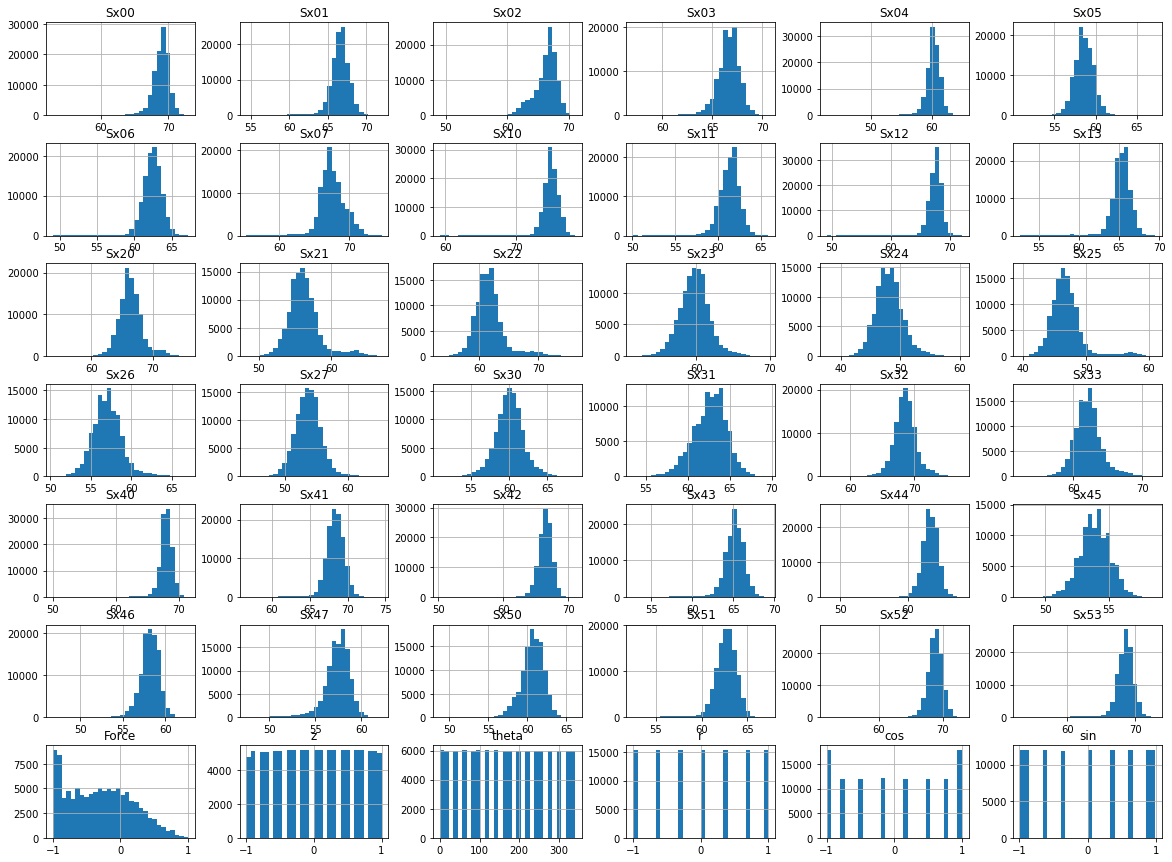

In [346]:
%matplotlib inline
import matplotlib.pyplot as plt
SDreal.hist(bins=30, figsize=(20,15))
plt.show()

In [347]:
SDy = SDreal.iloc[:,36:42]
SDy.describe()

,Force,z,theta,r,cos,sin
count,107827.000000,107827.000000,107827.000000,1.078270e+05,107827.000000,1.078270e+05
mean,-0.306217,0.004161,169.860425,-2.163960e-04,0.000363,1.946644e-03
std,0.469257,0.601821,103.755703,6.667238e-01,0.706528,7.076891e-01
min,-1.000000,-1.000000,0.000000,-1.000000e+00,-1.000000,-9.848078e-01
25%,-0.723634,-0.500000,80.000000,-6.666667e-01,-0.766044,-6.427876e-01
50%,-0.318762,0.000000,160.000000,2.220446e-16,-0.173648,1.224647e-16
75%,0.051313,0.500000,260.000000,6.666667e-01,0.766044,6.427876e-01
max,1.000000,1.000000,340.000000,1.000000e+00,1.000000,9.848078e-01


In [348]:
X = SDreal.iloc[:,0:36]
y = SDreal.iloc[:,[36,37,40,41]]

In [349]:
X

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Sx10,Sx11,...,Sx42,Sx43,Sx44,Sx45,Sx46,Sx47,Sx50,Sx51,Sx52,Sx53
0,64.5,68.1,61.9,66.0,55.8,58.9,60.3,65.3,74.5,57.2,...,65.2,62.9,60.0,49.0,55.0,50.7,58.6,61.4,65.6,68.3
1,64.7,67.4,62.1,66.2,55.4,58.9,60.1,65.4,75.0,57.5,...,64.8,62.6,60.0,49.0,55.0,50.7,58.2,62.2,65.0,68.6
2,65.1,67.3,62.1,65.8,55.1,58.9,60.1,65.4,75.2,57.6,...,64.5,62.0,60.4,49.2,55.2,50.8,58.0,62.0,64.7,68.3
3,65.4,67.1,62.2,65.8,54.8,58.9,60.4,64.8,75.7,57.7,...,64.3,62.5,60.0,49.0,55.5,51.0,58.6,62.2,64.5,68.6
4,65.4,67.3,61.3,65.7,54.8,59.1,61.0,64.8,76.1,58.2,...,64.2,62.6,59.8,49.5,55.1,50.8,58.2,62.3,65.0,68.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108255,70.1,66.9,65.9,67.5,61.0,57.9,62.0,67.7,75.6,61.2,...,67.2,65.4,63.7,54.9,57.8,57.3,61.8,62.7,70.0,67.4
108256,70.2,67.3,66.2,67.8,60.6,58.2,62.5,67.9,75.2,60.9,...,67.3,65.5,63.6,54.7,57.7,56.9,62.0,63.4,70.2,68.0
108257,69.3,67.2,66.8,67.1,60.2,58.4,62.1,68.6,75.8,61.8,...,66.3,65.5,64.6,54.9,57.8,57.2,61.2,62.9,69.2,68.3
108258,69.4,67.0,66.1,67.2,60.7,58.3,63.1,68.7,75.5,61.8,...,66.4,65.6,64.0,54.8,57.8,57.5,60.7,62.9,69.3,68.1


In [350]:
y

,Force,z,cos,sin
0,-0.921109,-1.0,1.000000,0.00000
1,-0.921779,-1.0,1.000000,0.00000
2,-0.921153,-1.0,1.000000,0.00000
3,-0.921421,-1.0,1.000000,0.00000
4,-0.921690,-1.0,1.000000,0.00000
...,...,...,...,...
108255,-0.883697,1.0,0.939693,-0.34202
108256,-0.884233,1.0,0.939693,-0.34202
108257,-0.884546,1.0,0.939693,-0.34202
108258,-0.884233,1.0,0.939693,-0.34202


In [351]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.01, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state=42)

In [352]:
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)

print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  85398 ea 79 %    X_valid:  21350 ea 19 %    X_test:  1079 ea 1 %


In [353]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [354]:
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_SS.pkl'
dump(scaler, file_name)

['myScaler/231007_1358_2kPa_160_Data_B17_SS.pkl']

In [355]:
from tensorflow import keras
model = keras.models.Sequential([  
    keras.layers.Dense(1024, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),            
    keras.layers.Dense(1024, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),                           
    keras.layers.Dense(1024, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),                           
    keras.layers.Dense(1024, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),                           
    keras.layers.Dense(4)
    
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 1024)              37888     
                                                                 
 dense_81 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_82 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_83 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_84 (Dense)            (None, 4)                 4100      
                                                                 
Total params: 3,190,788
Trainable params: 3,190,788
Non-trainable params: 0
_________________________________________________________________


## Callback (best, early stopping, tensorboard)

In [356]:
import os 
#root_logdir = os.path.join(os.curdir, 'mylog/'+data)
root_logdir = os.path.join(os.curdir, 'mylog/'+'231006_Data')

def get_run_logdir():
    import time
    run_id= time.strftime("%m%d_%Hh%Mm%Ss"+dataname)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [357]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [358]:
dataname

'231007_1358_2kPa_160_Data_B17'

In [359]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
n_epochs = 300
batch_size = 8
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle,early_stopping_cb,tensorboard_cb])
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:5]
y_pred = model.predict(X_new)

Epoch 1/300
2669/2669 [==============================] - 120s 45ms/step - loss: 1079.4814 - val_loss: 0.0788
Epoch 2/300
2669/2669 [==============================] - 119s 45ms/step - loss: 0.0565 - val_loss: 0.0494
Epoch 3/300
2669/2669 [==============================] - 116s 44ms/step - loss: 0.0379 - val_loss: 0.0356
Epoch 4/300
2669/2669 [==============================] - 119s 44ms/step - loss: 0.0285 - val_loss: 0.0313
Epoch 5/300
2669/2669 [==============================] - 117s 44ms/step - loss: 0.0227 - val_loss: 0.0290
Epoch 6/300
2669/2669 [==============================] - 117s 44ms/step - loss: 0.0184 - val_loss: 0.0213
Epoch 7/300
2669/2669 [==============================] - 116s 44ms/step - loss: 0.0162 - val_loss: 0.0177
Epoch 8/300
2669/2669 [==============================] - 119s 45ms/step - loss: 0.0143 - val_loss: 0.0207
Epoch 9/300
2669/2669 [==============================] - 118s 44ms/step - loss: 0.0129 - val_loss: 0.0156
Epoch 10/300
2669/2669 [===================

In [360]:
# %load_ext tensorboard
# %tensorboard --logdir=./mylog/230320_Data --port=2322

In [361]:
model.save('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/TACTS/TACTS_v3/myModel/'+dataname+'.h5')

In [362]:
model = tf.keras.models.load_model('myModel/'+dataname+'.h5')
scaler = load(file_name)
valid_predictions = model.predict(X_valid)

valid_predictions_df=pd.DataFrame(valid_predictions)
#valid_predictions_df.columns = ["valid_force","valid_z"]
#valid_predictions_df.columns = ["valid_force","valid_z","valid_r"]
valid_predictions_df.columns = ["valid_force","valid_z","valid_cos","valid_sin"]
#valid_predictions_df.columns = ["valid_force","valid_z","valid_r","valid_cos","valid_sin"]
valid_theta_rad = np.arctan2(valid_predictions_df['valid_sin'], valid_predictions_df['valid_cos'])
valid_theta_deg = np.degrees(valid_theta_rad)
valid_predictions_df['valid_theta'] = valid_theta_deg
valid_predictions_df['valid_theta'] /= 180
valid_predictions_df

668/668 [==============================] - 7s 11ms/step


,valid_force,valid_z,valid_cos,valid_sin,valid_theta
0,0.294850,-0.528323,0.758367,0.658111,0.227508
1,0.027858,-0.712487,0.888695,-0.418657,-0.140137
2,0.259789,-0.049996,-0.188917,0.946135,0.562732
3,-0.423454,0.728485,0.769520,-0.581120,-0.205884
4,0.020665,0.385884,0.981414,0.448149,0.136351
...,...,...,...,...,...
21345,-0.235524,0.242765,0.153195,-1.046029,-0.453711
21346,-0.078998,-0.074218,-0.985183,-0.001448,-0.999532
21347,-0.418765,0.638898,0.511706,0.817371,0.321955
21348,0.334596,-0.204457,-0.175263,-1.047321,-0.552778


In [363]:
k= y_valid.to_numpy()
k_df = pd.DataFrame(k)
k_df.columns  = ["force","z","cos","sin"]
#k_df.columns  = ["force","z","r","cos","sin"]
theta_rad = np.arctan2(k_df['sin'], k_df['cos'])
theta_deg = np.degrees(theta_rad)
k_df['theta'] = theta_deg
k_df['theta'] /= 180
k_df

,force,z,cos,sin,theta
0,0.431087,-0.5,0.766044,6.427876e-01,0.222222
1,0.074757,-0.7,0.939693,-3.420201e-01,-0.111111
2,0.268522,0.0,-0.173648,9.848078e-01,0.555556
3,-0.320192,0.6,0.766044,-6.427876e-01,-0.222222
4,-0.147391,0.5,0.939693,3.420201e-01,0.111111
...,...,...,...,...,...
21345,-0.305308,0.3,0.173648,-9.848078e-01,-0.444444
21346,-0.016605,-0.2,-1.000000,1.224647e-16,1.000000
21347,-0.324662,0.7,0.500000,8.660254e-01,0.333333
21348,0.406191,-0.2,-0.173648,-9.848078e-01,-0.555556


In [364]:
ValidPre = pd.concat( [k_df,valid_predictions_df],axis=1)
ValidPre.head(5)
corr = ValidPre.corr()
print("corr")
n = k_df.shape[1]
for i in range(0,n):    
    print(format(corr[valid_predictions_df.columns[i]][k_df.columns[i]]*100,'.2f')+'%',k_df.columns[i])
corr_matrix = pd.DataFrame(index=k_df.columns, columns=valid_predictions_df.columns)

# 각 열과 행의 상관관계 계산
for k_col in k_df.columns:
    for valid_col in valid_predictions_df.columns:
        corr2 = np.corrcoef(k_df[k_col], valid_predictions_df[valid_col])[0, 1]
        corr_matrix.loc[k_col, valid_col] = corr2
corr_matrix

corr
97.03% force
98.72% z
98.91% cos
99.06% sin
81.50% theta


,valid_force,valid_z,valid_cos,valid_sin,valid_theta
force,0.970258,-0.157155,0.413085,0.051115,0.046936
z,-0.15532,0.987206,-0.03689,0.012037,0.020006
cos,0.458454,-0.053935,0.98908,-0.006652,0.006787
sin,0.008977,0.003063,-0.00574,0.990595,0.774364
theta,-0.077542,0.011947,-0.136868,0.763123,0.815007


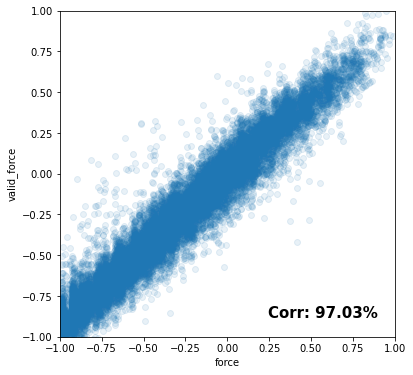

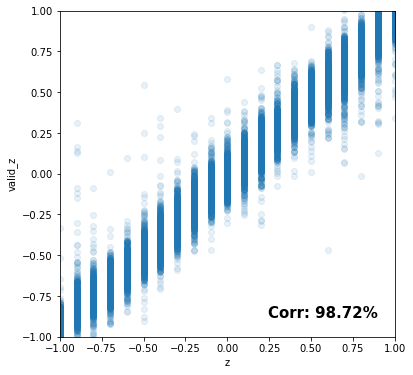

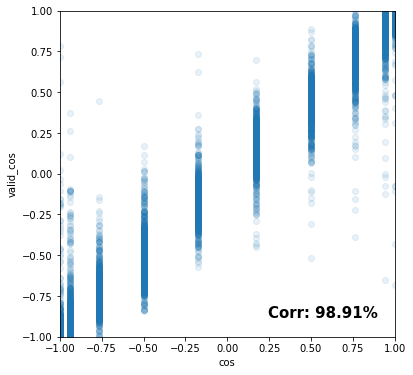

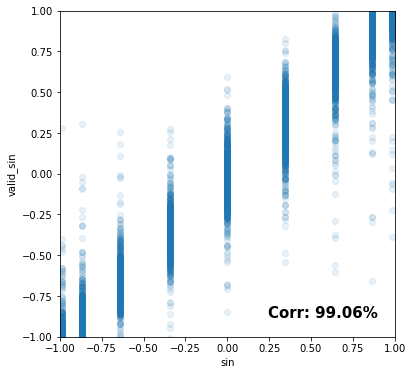

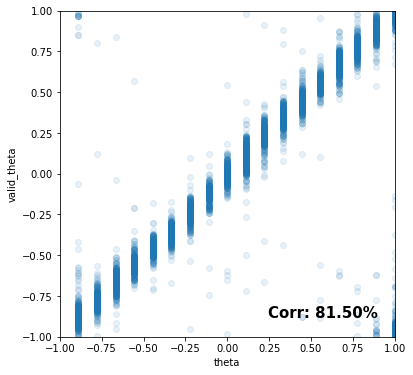

In [365]:
import pandas as pd
import os
import matplotlib.pyplot as plt

alpa = 0.1
output_dir = "myLearningData/savefig"  # 저장할 폴더 이름

# 폴더가 없는 경우 폴더를 생성합니다.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

fields = ['force','z','cos','sin','theta']
#fields = ['force','z','r','cos','sin','theta']

for field in fields:
    plt.figure(figsize=(6, 6))  # Set the figure size to 1:1
    plt.scatter(ValidPre[field], ValidPre[f"valid_{field}"], alpha=alpa)
    plt.xlabel(field)
    plt.ylabel(f"valid_{field}")
    plt.xlim(-1, 1)  # x축 범위 설정
    plt.ylim(-1, 1)  # y축 범위 설정

    # Compute the correlation value to be added
    corr_value = format(corr[f"valid_{field}"][field]*100,'.2f') + '%'
    plt.text(0.95, 0.05, f'Corr: {corr_value}', ha='right', va='bottom', 
             transform=plt.gca().transAxes, fontsize=15, weight='bold')

    plt.savefig(os.path.join(output_dir, f"{dataname}_{field}.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장
    plt.show()


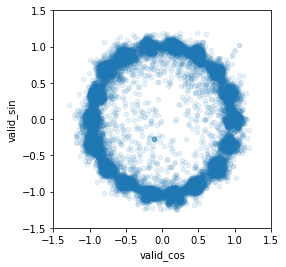

In [366]:
alpa = 0.1  # assuming you've set alpha to this value, adjust as needed
ax = ValidPre.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpa)

# Set the aspect ratio to be equal
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장

# Display the plot
plt.show()

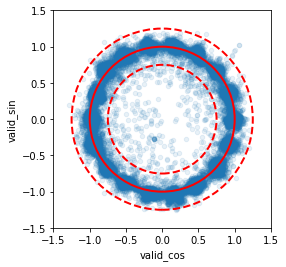

In [367]:
alpha = 0.1  # set alpha value for scatter plot
ax = ValidPre.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpha)

# Draw a circle with center at (0, 0) and radius 1
circle = plt.Circle((0, 0), 1, color='r', fill=False, linewidth=2)
ax.add_artist(circle)

# Draw offset circles (one inside and one outside the main circle)
offset = 0.25  # adjust the offset value as needed
inner_circle = plt.Circle((0, 0), 1 - offset, color='r', linestyle='--', fill=False, linewidth=2)
outer_circle = plt.Circle((0, 0), 1 + offset, color='r', linestyle='--', fill=False, linewidth=2)
ax.add_artist(inner_circle)
ax.add_artist(outer_circle)

# Set the aspect ratio to be equal
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정
# Display the plot
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle_offset.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장

plt.show()


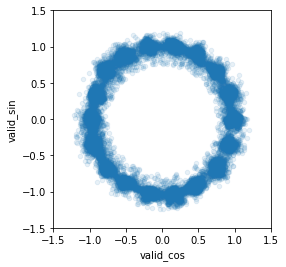

1.8032786885245904

In [368]:
ValidPre_filtered = ValidPre[
    (ValidPre['valid_cos']**2 + ValidPre['valid_sin']**2 <= (1 + offset)**2) &
    (ValidPre['valid_cos']**2 + ValidPre['valid_sin']**2 >= (1 - offset)**2)
]


ax = ValidPre_filtered.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpha)
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle_cut.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장

plt.show()

total_data_count = len(ValidPre)
filtered_data_count = len(ValidPre_filtered)
percentage_filtered_out = ((total_data_count - filtered_data_count) / total_data_count) * 100
percentage_filtered_out

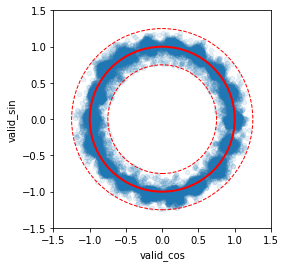

In [369]:
# 기존의 scatter plot을 그립니다.
ax = ValidPre_filtered.plot(kind="scatter", x="valid_cos", y="valid_sin", alpha=alpha)

# 중심이 (0, 0)이고 반지름이 1인 실선 원을 추가합니다.
circle = plt.Circle((0, 0), 1, color='r', fill=False, linewidth=2)
ax.add_artist(circle)

# 점선 원을 추가합니다. 하나는 내부에, 하나는 외부에 위치합니다.
offset = 0.25  # offset 값을 필요에 따라 조정합니다.
inner_circle = plt.Circle((0, 0), 1 - offset, color='r', linestyle='--', fill=False, linewidth=1)
outer_circle = plt.Circle((0, 0), 1 + offset, color='r', linestyle='--', fill=False, linewidth=1)
ax.add_artist(inner_circle)
ax.add_artist(outer_circle)

# 그래프의 비율을 1:1로 설정합니다.
ax.set_aspect('equal', 'box')
plt.xlim(-1.5, 1.5)  # x축 범위 설정
plt.ylim(-1.5, 1.5)  # y축 범위 설정

# 그래프를 파일로 저장합니다.
plt.savefig(os.path.join(output_dir, f"{dataname}_Circle_cut_offset.png"))

# 그래프를 출력합니다.
plt.show()
